# 基于几何代数匹配滤波器的间歇采样转发干扰验证

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import stats
from scipy import signal
import sys

### 线性调频信号
$y=\frac{1}{\sqrt{T}}e^{j{\pi}\frac{B}{T}t^2}$

*B为扫频宽度，$T$为脉冲宽度*

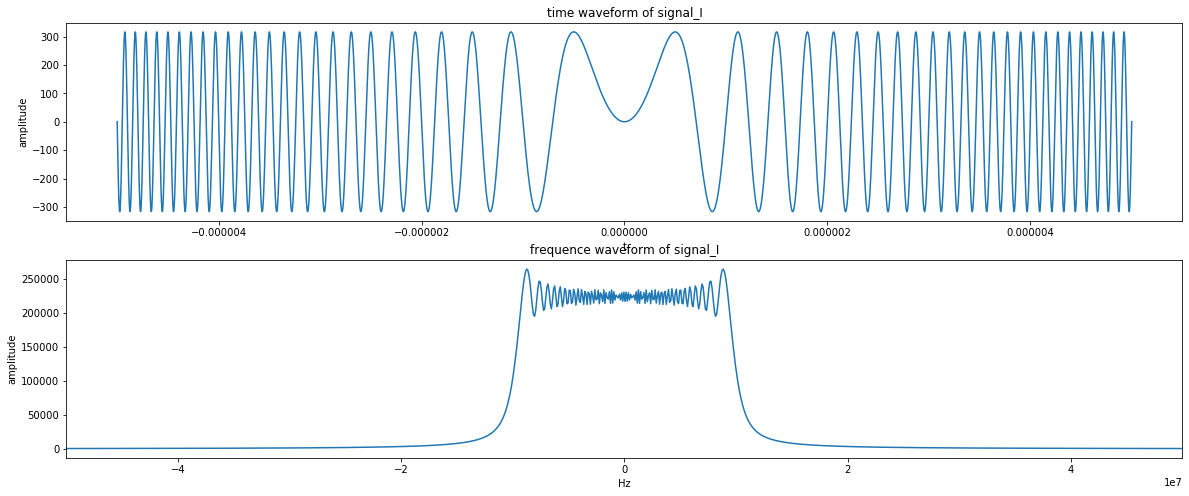

In [2]:

#### 参数设置

pluseWidth = 10e-6    # 脉冲宽度(持续时间s)
prf = 1e3            # 重复频率Hz
# B = 20e6              # 扫频宽度

fs = 1e9            # 采样频率Hz

lightSpeed = 3e8     # 光速


#### 信号产生
def LFM_create(B):
    sig = np.exp(1j*np.pi*B/pluseWidth*(t**2))/np.sqrt(pluseWidth)
    sig_I = np.real(sig)
    sig_Q = np.imag(sig)
    
    return sig_I+1j*sig_Q

t = np.linspace(-pluseWidth/2, pluseWidth/2, int(fs*pluseWidth))
T = np.linspace(0, 1/prf, int(fs/prf))


sig = LFM_create(20e6)
sig1= LFM_create(300e6)

fftI = np.abs(np.fft.fft(sig))
fftI = np.concatenate((fftI[-len(fftI)//2:],fftI[0:len(fftI)//2]))

#### 作图
plt.figure(figsize=(20, 8))

plt.subplot('211')
plt.plot(t, np.imag(sig))
plt.xlabel('t')
plt.ylabel('amplitude')
plt.title('time waveform of signal_I')

plt.subplot('212')
plt.plot(np.linspace(-fs/2, fs/2, int(fs*pluseWidth)), fftI)
plt.xlabel('Hz')
plt.ylabel('amplitude')
# plt.yscale('log')
plt.xlim(xmin=-5e7,xmax=5e7)
plt.title('frequence waveform of signal_I')

plt.show()

### 模糊函数
---
#### 1.信号s(t)的雷达模糊函数定义：

$|\chi(\tau;f_d)|^2=|\int_{-\infty}^{+\infty}s(t)s^{*}(t-\tau)e^{j2{\pi}f_dt}dt|^2$

$\tau$为时延，$f_d$为多普勒频移

### 匹配滤波
---
频域运算：$y(t)=IFFT[X(f)X^{*}(f)]$

时域运算：$y(t)=x(t)*x^{*}(-t)$

* 匹配滤波器是最佳线性滤波器的一种，该滤波器的准则是输出信噪比最大，表达式为：$h(f)=x^{*}(f)$

* 从幅频特性来看，匹配滤波器和输入信号的幅频特性完全一样。在信号越强的频率点，滤波器的放大倍数也越大；在信号越弱的频率点，滤波器的放大倍数也越小。匹配滤波器是让信号尽可能通过，而不管噪声的特性。因为匹配滤波器的一个前提是白噪声，也即是噪声的功率谱是平坦的，在各个频率点都一样。

* 从相频特性上看，匹配滤波器的相频特性和输入信号正好完全相反。这样，通过匹配滤波器后，信号的相位为0，正好能实现信号时域上的相干叠加。而噪声的相位是随机的，只能实现非相干叠加。这样在时域上保证了输出信噪比的最大。



### 间歇采样转发干扰
---
#### 1.应用背景

* 宽带雷达信号的⾼速采样问题
* 收发天线同时⼯作带来的隔离度问题

---
#### 2.间歇采样信号
* 间歇采样信号是一个矩形脉冲串p(t):


<font color='red'>$p(t)=rect(\frac{t}{\tau})*\sum_{-\infty}^{+\infty}\delta(t-nT_s)=\frac{\tau}{T_s}+\frac{2\tau}{T_s}sa(n{\pi}f_s\tau)cos(2{\pi}nf_st)$</font>


$\tau$为脉宽，$T_s$为间歇采样周期，$f_s=\frac{1}{T_s}$

---
* 设雷达发射信号为x(t)，其脉宽为$\tau$，带宽为B，频谱为X(f)；⼲扰机收到雷达信号后，对其进⾏间歇采样处理，即以p(t)与其做相乘运算，得采样信号为：

时域形式：<font color='red'>$x_s(t)=p(t)x(t)$</font>

频域形式：<font color='red'>$X_s(f)=\sum_{-\infty}^{+\infty}a_nX(f-nf_s)$</font>；$a_n={\tau}f_ssa({\pi}nf_s\tau)$

<font color='red'>$X_s(f)$是$f(x)$的周期加权延拓，延拓周期为$T_s$，幅度加权系数为$a_n$</font>



#### 3.间歇采样频率⼤于雷达信号带宽时的⼲扰效果
---
设雷达发射信号为x(t)，其脉宽为T，其带宽B⼩于间歇采样频率$f_s$。对其进⾏间歇采样转发处理，得到⼲扰信号为$x_s(t)$，其频谱$X_s(f)$，可知，$X_s(f)$的频谱中<font color='red'>仅有n=0这⼀项对应的频谱分量落⼊匹配滤波器$X^{*}(f)$的带宽内</font>，故得间歇采样转发信号经匹配滤波器后的输出信号频谱为：

<font color='red'>$Y_s(f)=a_0X(f)X^{*}(f)=a_0|X(f)|^2$</font>

$a_0={\tau}f_s$；采样占空比

上式表明，对于经间歇采样转发形成的⼲扰信号，当采样频率⾜够⾼时，则⼲扰信号经雷达匹配滤波处理后，其输出波形与真实⽬标回波信号的匹配滤波输出波形完全相同，⼆者仅在幅度上相差⼀个采样占空⽐${\tau}f_s$

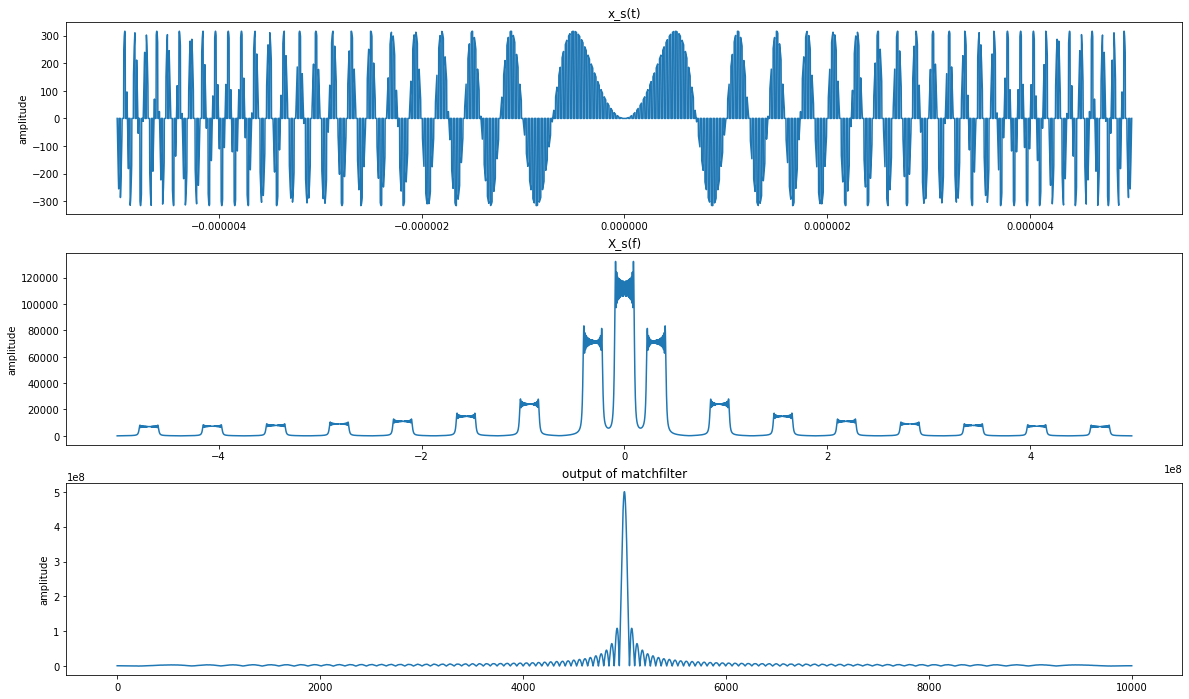

In [3]:

#### 参数设置
# Ts = pluseWidth/300  # 切片份数
# pw = Ts/2   # 占空比

#### 干扰产生
def jamCreate(Ts,pw):
    rect = np.array([])
    while len(rect)<len(sig):
        rect = np.concatenate((rect,np.ones(int(pw*fs))))
        rect = np.concatenate((rect,np.zeros(int((Ts-pw)*fs))))

    rect = rect[0:len(sig)]
    jam_I = np.multiply(rect,np.real(sig))
    jam_Q = np.multiply(rect,np.imag(sig))
    return jam_I+1j*jam_Q

jam = jamCreate(1/(3e7),1/(3e7)/2) # 3e7>B=20e6
fft_jam = np.abs(np.fft.fft(jam))
fft_jam = np.concatenate((fft_jam[-len(fft_jam)//2:],fft_jam[0:len(fft_jam)//2]))


#### 干扰信号匹配滤波
match2 = np.fft.ifft(np.fft.fft(jam)*np.fft.fft(np.conj(sig)))
match2 = np.concatenate((match2[-len(match2)//2:],match2[0:len(match2)//2]))

#### 作图

plt.figure(figsize=(20, 12))

plt.subplot('311')
plt.plot(t, np.imag(jam))
plt.ylabel('amplitude')
plt.title('x_s(t)')

plt.subplot('312')
plt.plot(np.linspace(-fs/2, fs/2, int(fs*pluseWidth)), fft_jam)
plt.ylabel('amplitude')
# plt.yscale('log')
plt.title('X_s(f)')

plt.subplot('313')
plt.plot(np.abs(match2))
plt.ylabel('amplitude')
plt.title('output of matchfilter')

plt.show()

#### 4.间歇采样频率低于信号带宽
---
矩形包络脉冲串：

$p(t)=\frac{\tau}{T_s}+\frac{2\tau}{T_s}sa(n{\pi}f_s\tau)cos(2{\pi}nf_st)$

转发干扰信号：

$x_s(t)=x(t)p(t)=\frac{\tau}{T_s}x(t)+\frac{2\tau}{T_s}sa(n{\pi}f_s\tau)cos(2{\pi}nf_st)x(t)$

干扰信号通过匹配滤波后的输出：

$y_s(t)=x_s(t)*h(t)=\frac{\tau}{T_s}y(t)+\frac{2\tau}{T_s}sa(n{\pi}f_s\tau)cos(2{\pi}nf_st)y(t)$

---
分析：
由上式可以看出，干扰使脉冲压缩雷达产生一个逼真的主假目标（第一项：$\frac{\tau}{T_s}y(t)$），和一串在径向距离上以主假目标为中心，对称分布的假目标串回波信号

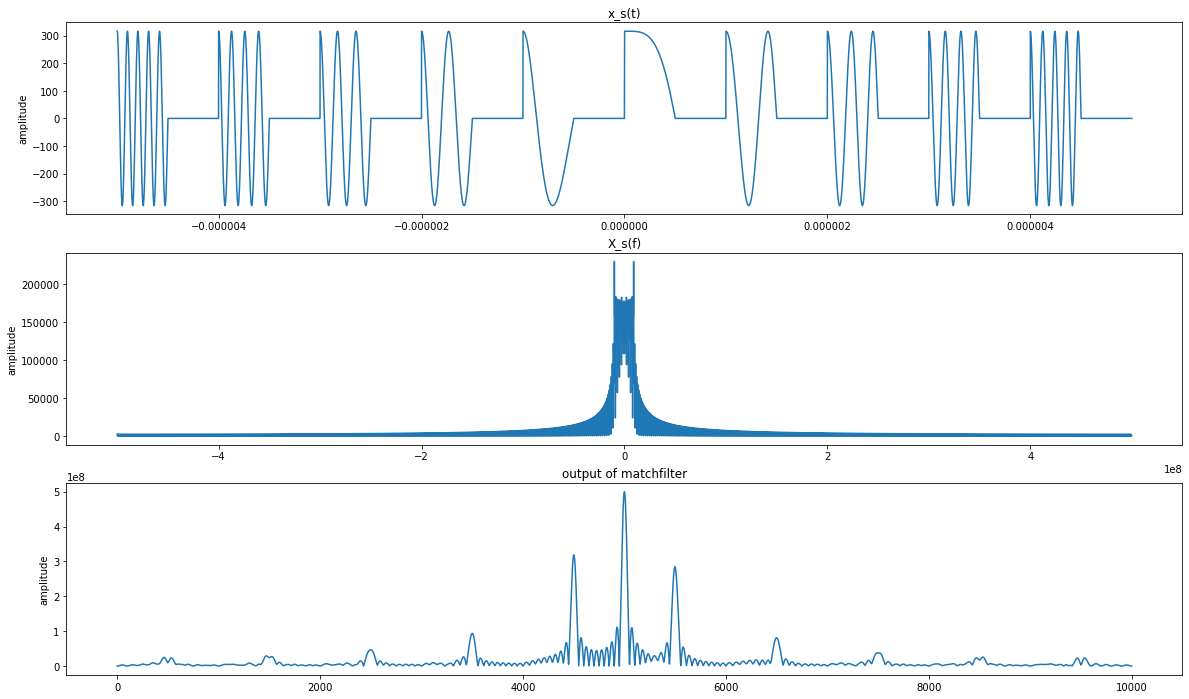

In [4]:
jam = jamCreate(1/(1e6),1/(1e6)/2)
fft_jam = np.abs(np.fft.fft(jam))
fft_jam = np.concatenate((fft_jam[-len(fft_jam)//2:],fft_jam[0:len(fft_jam)//2]))


#### 干扰信号匹配滤波
match2 = np.fft.ifft(np.fft.fft(jam)*np.fft.fft(np.conj(sig)))
match2 = np.concatenate((match2[-len(match2)//2:],match2[0:len(match2)//2]))

#### 作图

plt.figure(figsize=(20, 12))

plt.subplot('311')
plt.plot(t, np.real(jam))
plt.ylabel('amplitude')
plt.title('x_s(t)')

plt.subplot('312')
plt.plot(np.linspace(-fs/2, fs/2, int(fs*pluseWidth)), fft_jam)
plt.ylabel('amplitude')
# plt.yscale('log')
plt.title('X_s(f)')

plt.subplot('313')
plt.plot(np.abs(match2))
plt.ylabel('amplitude')
plt.title('output of matchfilter')

plt.show()

#### 5.干扰参数分析
---
选取不同的间歇占空比duty与不同的间歇频率fs进行对比实验

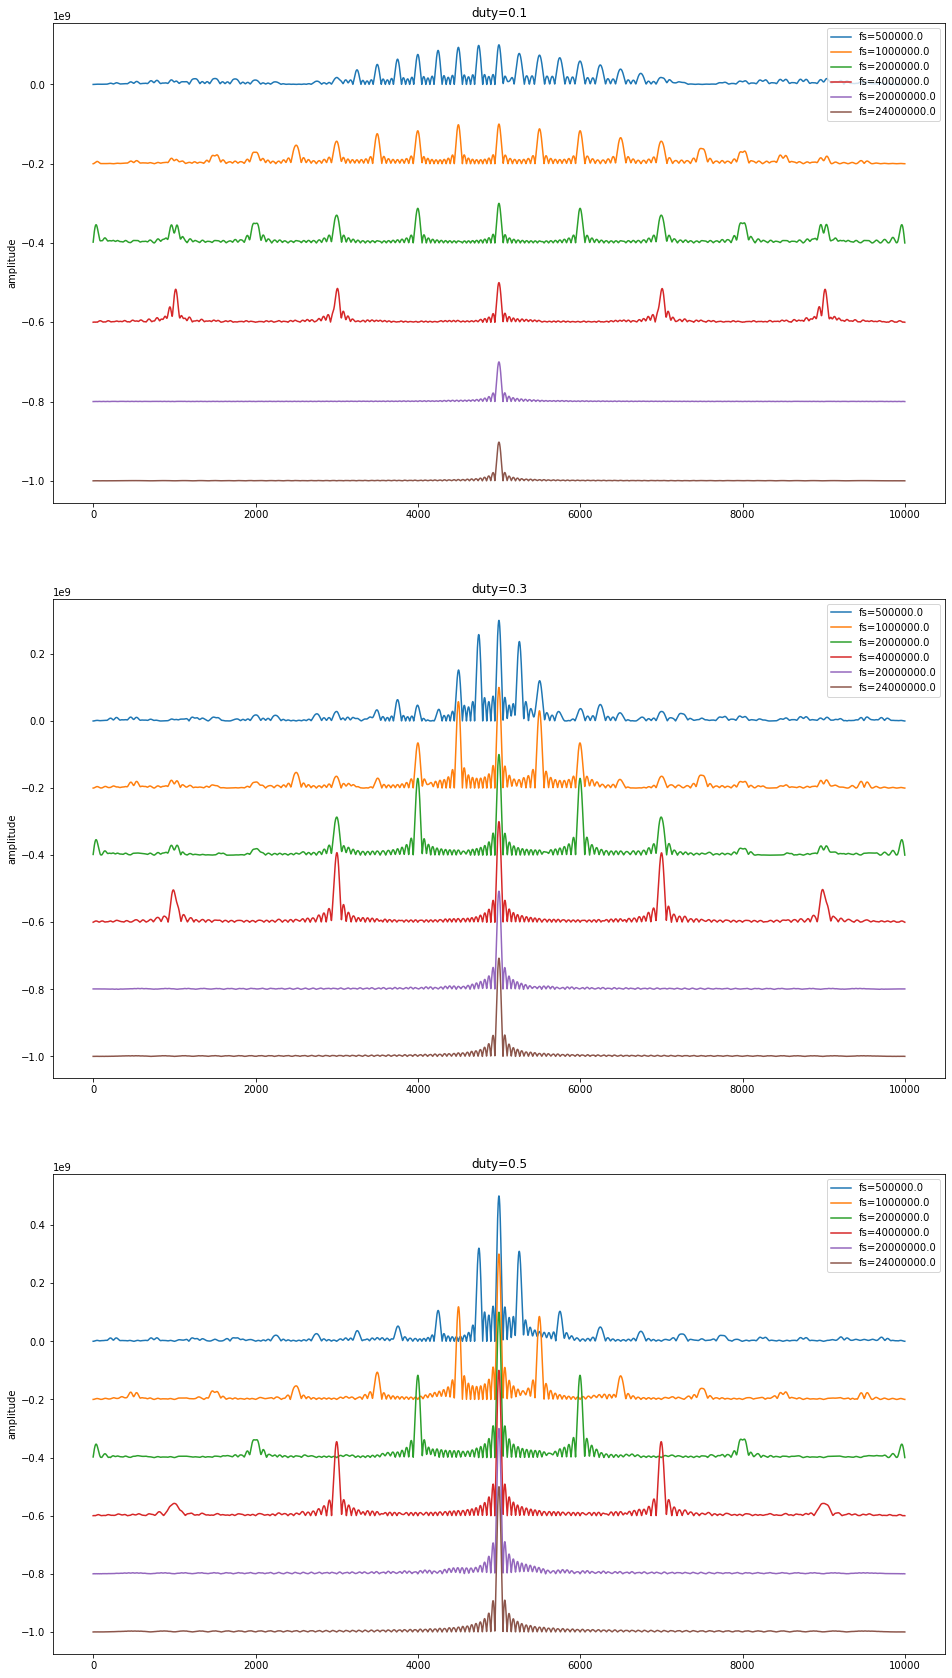

In [5]:
B = 20e6
jamm = np.zeros((3,6,len(match2)))
duty = [0.1,0.3,0.5]
samp = [B/40,B/20,B/10,B/5,B,1.2*B]
for i in range(len(duty)):
    for j in range(len(samp)):
        jam = jamCreate(1/samp[j],1/samp[j]*duty[i])
        
        fft_jam = np.abs(np.fft.fft(jam))
        fft_jam = np.concatenate((fft_jam[-len(fft_jam)//2:],fft_jam[0:len(fft_jam)//2]))


        #### 干扰信号匹配滤波
        match2 = np.fft.ifft(np.fft.fft(jam)*np.fft.fft(np.conj(sig)))
        match2 = np.concatenate((match2[-len(match2)//2:],match2[0:len(match2)//2]))
        jamm[i][j] = np.abs(match2)


# 画图
plt.figure(figsize=(16, 30))

plt.subplot('311')
for i in range(len(jamm[0])):
    plt.plot(jamm[0][i]-i*2e8,label='fs='+str(samp[i]))
plt.ylabel('amplitude')
plt.title('duty='+str(duty[0]))
plt.legend(loc='best')
        
plt.subplot('312')
for i in range(len(jamm[1])):
    plt.plot(jamm[1][i]-i*2e8,label='fs='+str(samp[i]))
plt.ylabel('amplitude')
plt.title('duty='+str(duty[1]))
plt.legend(loc='best')

plt.subplot('313')
for i in range(len(jamm[2])):
    plt.plot(jamm[2][i]-i*2e8,label='fs='+str(samp[i]))
plt.ylabel('amplitude')
plt.title('duty='+str(duty[2]))
plt.legend(loc='best')

plt.show()

#### 6.分析
---
* 当间歇频率$f_s$小于线性调频信号带宽B时：

    峰值点出现在：$t_{max}=-\frac{nf_sT}{B}$

    相邻两阶信号的峰值点相距（时差）：${\bigtriangleup}t=\frac{f_sT}{B}$

    峰值点的幅度近似为：$|y_s(t_{max})|=1-|nf_s|\frac{T}{B}$

    脉宽近似为：${\tau}_{ys}=\frac{1}{B-|nf_s|}$

当$nf_s$逐渐增大接近B时，上面四个式子的正确性将降低

* 当间歇频率$f_s$大于等于线性调频带宽B时：

    其输出波形与目标回波信号的脉压输出完全相同，仅在幅度上相差一个常数系数${\tau}f_s$

### 几何代数匹配滤波器
---
匹配滤波器时域公式：$y[n]=\sum_{P=0}^{P-1}h[P]x[n-P], n=0,1,...,N+P-1$

其中$x[n]$为输入信号，$h[p]$为匹配滤波器冲激响应，$y[n]$为匹配滤波器输出

---
也可以简写成：$y=Xh$

X为：$\begin{bmatrix}x[1] & \cdots & 0 \\ \vdots & \ddots & x[1] \\ x[N] & \ddots & \vdots \\ \vdots & \ddots & \vdots \\ 0 & \cdots & x[N] \end{bmatrix}_{(N+P-1){\times}P}=\begin{bmatrix} \vec{X1} \\ \vdots \\ \vec{X_{N+P-1}} \end{bmatrix}$

y为：$\begin{bmatrix} y[1] & \cdots & y[N+P-1] \end{bmatrix}^T$

h为：$\begin{bmatrix} h[0] & \cdots & h[P-1] \end{bmatrix}^T$

由上式可得，匹配滤波器的输出可以看作由x的行矢量与h的内积得到

---
根据《多普勒雷达几何代数检测器》中的定理X可得，$C^P$中的内积操作可等价于$G^{2P}$中的投影操作，投影角矢量可写为：

$\Psi=[\psi_1,...,\psi_{N+P-1}]^T=\begin{bmatrix} cos^{-1}{\frac{|X_1{\cdot}h|}{|X_1||h|}}, & \cdots & cos^{-1}{\frac{|X_{N+P-1}{\cdot}h|}{|X_{N+P-1}||h|}} \end{bmatrix}^T$


### 实验验证

---

<ipython-input-10-d69edf098edb>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  x[i][i:L+i] = jam
<ipython-input-10-d69edf098edb>:12: RuntimeWarning: invalid value encountered in double_scalars
  angle[i] = np.arccos(np.abs(x[i].dot(h))/(np.linalg.norm(x[i])*norm_h))


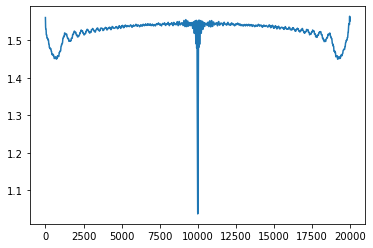

In [10]:
L = len(jam)
x = np.zeros((L,2*L-1),dtype=complex)
for i in range(L):
    x[i][i:L+i] = jam

x = x.T
print(x)
'''
h = np.conj(np.flipud(sig)).T

angle = np.zeros(2*L-1)
norm_h = np.linalg.norm(h)
for i in range(len(angle)):
    angle[i] = np.arccos(np.abs(x[i].dot(h))/(np.linalg.norm(x[i])*norm_h))

plt.plot(angle)
plt.show()
'''